In [1]:
import jax 
from jax import numpy as jnp

from matplotlib import pyplot as plt

from kalman_gmm import run_kalman_filters

In [2]:
def generate_data(B, T, N, D, K, D_s, key):
    A_true = jnp.array([[1.0, 0.1], [0.0, 1.0]])  # [D_s, D_s]
    Q_true = jnp.array([[0.01, 0.0], [0.0, 0.01]])  # [D_s, D_s]
    H_true = jnp.eye(D_s)  # [D, D_s]
    R_true = jnp.array([jnp.eye(D) * 0.1, jnp.eye(D) * 0.1])  # [K, D, D]

    x0_components = jnp.array([[0.0, 1.0], [5.0, -1.0]]) # [K, D_s]
    x0_true = jnp.tile(x0_components[None, :, :], (B, 1, 1))  # [B, K, D_s]

    # Initialize true states and observations
    x_true = jnp.zeros((B, T, K, D_s))
    y_data = jnp.zeros((B, T, N, D))

    # Create an array of keys for random number generation across time steps
    keys = jax.random.split(key, T * B * N * K * 2)

    key_idx = 0  
    for t in range(T):
        if t == 0:
            x_t = x0_true  # Set initial state; [B, K, D_s]
        else:
            process_noise = jax.random.normal(keys[key_idx], (B, K, D_s)) * jnp.sqrt(Q_true.diagonal())
            key_idx += 1
            x_t = jnp.einsum("ij,bkj->bki", A_true, x_true[:, t - 1, :, :]) + process_noise  # [B, K, D_s]

        y_t = jnp.zeros((B, N, D))

        for b in range(B):
            for n in range(N):
                k = jax.random.choice(keys[key_idx], K)
                key_idx += 1
                mean = jnp.dot(H_true, x_t[b, k, :])  # [D]
                observation_noise = jax.random.normal(keys[key_idx], (D,)) * jnp.sqrt(R_true[k].diagonal())
                key_idx += 1
                y_t = y_t.at[b, n, :].set(mean + observation_noise)

        x_true = x_true.at[:, t, :, :].set(x_t)  # [B, T, K, D_s]
        y_data = y_data.at[:, t, :, :].set(y_t)  # [B, T, N, D]

    return y_data, x_true, H_true, A_true, Q_true, R_true

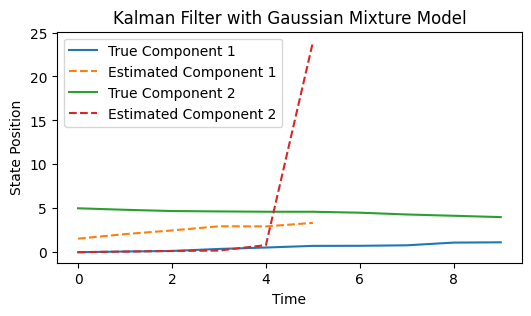

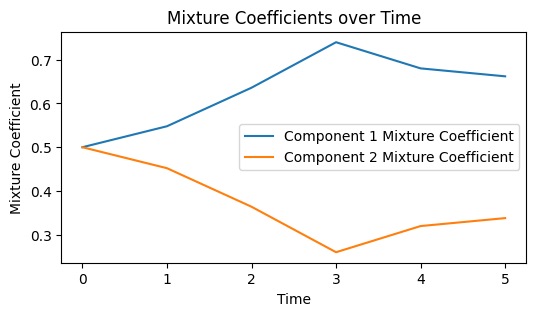

In [3]:
key = jax.random.PRNGKey(0)
B = 1  # Batch size
T = 10  # Time steps
N = 50  # Number of pixels
D = 2  # Observation dimension 
K = 2  # Number of components
D_s = 2  # State dimension

y_data, x_true, H_true, A_true, Q_true, R_true = generate_data(B, T, N, D, K, D_s, key)

x_init_k = jnp.zeros((B, K, D_s))
P_init_k = jnp.tile(jnp.eye(D_s)[None, None, :, :], (B, K, 1, 1))
pi_init = jnp.ones((B, K)) / K
R_init_k = jnp.tile(jnp.eye(D)[None, None, :, :], (B, K, 1, 1))

x_estimates, pi_estimates = run_kalman_filters(y_data, K, H_true, A_true, Q_true, x_init_k, P_init_k, pi_init, R_init_k)

plt.figure(figsize=(6, 3))
time = jnp.arange(T)
for k in range(K):
    plt.plot(time, x_true[0, :, k, 0], label=f"True Component {k+1}")
    plt.plot(time, x_estimates[0, :, k, 0], "--", label=f"Estimated Component {k+1}")
plt.xlabel("Time")
plt.ylabel("State Position")
plt.title("Kalman Filter with Gaussian Mixture Model")
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
for k in range(K):
    plt.plot(time, pi_estimates[0, :, k], label=f"Component {k+1} Mixture Coefficient")
plt.xlabel("Time")
plt.ylabel("Mixture Coefficient")
plt.title("Mixture Coefficients over Time")
plt.legend()
plt.show()